# Introduction

The *pyveg* package contains some useful functions for interacting with the Python API of Google Earth Engine.

However, before we can use GEE, we need to authenticate (assuming we have an account).

In [1]:
import ee
ee.Authenticate()

Enter verification code: 4/ygGFfWk4W_K0q3TTp2Fglz_jhLvFys8UJm1_4ICb4ePiNrsMJxioysw

Successfully saved authorization token.


## Import code from the pyveg package

In pyveg, the functions that interact directly with Google Earth Engine are in the *gee_interface.py* module.

In [2]:
from pyveg.src.gee_interface import *

## Prepare data - get download URL

To specify what we want to download, we create a dictionary.  There is a file *config.py* in pyveg that demonstrates the format (and this is the default one that will be used if you use the command line entrypoint *pyveg_gee_download*).

For this example, let's download some Sentinel 2 NDVI data:

In [7]:
collection_dict = {
        'collection_name': 'COPERNICUS/S2',
        'type': 'vegetation',
        'RGB_bands': ('B4','B3','B2'),
        'NIR_band': 'B8',
        'cloudy_pix_flag': 'CLOUDY_PIXEL_PERCENTAGE',
}


we also need to specify the coordinates we want to look at (in ***(long,lat)*** format) - let's look at one of our locations in the Sahel:

In [4]:
coords = [28.37,11.12]

And we need to choose a date range.  If we are looking at vegetation data as in this case, we will take the median of all images available within this date range (after filtering out cloudy ones).

In [9]:
date_range = ["2018-06-01","2018-07-31"]

Now we're ready to talk to our GEE interface:

In [10]:
urls = ee_prep_data(collection_dict, coords, date_range)

Found 8 valid images of 12 total images in this date range.


GEE has given us a URL from where we can download a zipfile, that will in contain one .tif file per band.

In [12]:
urls[0]

['https://earthengine.googleapis.com/api/download?docid=f7838442e474008d3d70434d4fb3e7bf&token=1ec733dd57fcb0d2a67971db054bb78d']

## Downloading and unzipping 

We need to choose a directory in which to put the unzip-ed .tif files.   Let's just use a temporary directory.

In [29]:
tif_filebase = download_and_unzip(urls[0][0], "/tmp/gee_test_veg")[0]

## Constructing RGB, NDVI, and binary images.

So we have some .tif files locally (one per band), but they're not that interesting to look at (most image viewing software won't interpret the pixel values in a way that we can see).

The first and simplest thing we can do is to create an RGB image from those three bands.

In [21]:
from pyveg.src.image_utils import *

In [30]:
rgb_img = convert_to_rgb(tif_filebase,collection_dict["RGB_bands"])

We have to jump through a few hoops to look at this image in a jupyter notebook, but in a script you could just do rgb_img.save(<filename>).

In [31]:
from matplotlib.pyplot import imshow
import numpy as np

In [32]:
%matplotlib inline

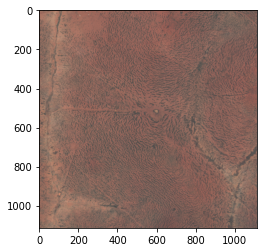

In [33]:
imshow(np.asarray(rgb_img))

## Single band image (e.g. NDVI)

OK, let's look at the NDVI image.  Again the tif file will only contain one value per pixel - if we want to look at it we need to set r,g,b pixel values to somewhere in the 8-bit colour range to get a greyscale image.

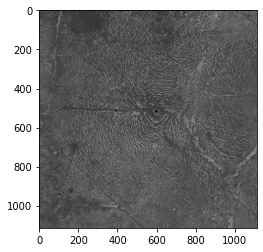

In [35]:
ndvi_img = scale_tif(tif_filebase, "NDVI")
imshow(np.asarray(ndvi_img))

## Image processing and thresholding

For our vegetation study, we want to create a binary image from this, where vegetation is in black, and bare soil is white.

We have a function in pyveg that does histogram equalization, adaptive thresholding and median filtering on an input image, to give us a binary version:

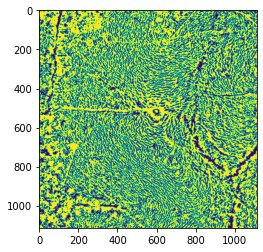

In [37]:
binary_img = process_and_threshold(ndvi_img)
imshow(np.asarray(binary_img))

## Getting weather data.

For our study, we are also interested in the precipitation for this region, and this time range.
We can use the ERA5 dataset for this.

In [43]:
collection_dict = {
        'collection_name': 'ECMWF/ERA5/MONTHLY',
        'type': 'weather',
        'precipitation_band': ['total_precipitation'],
        'temperature_band': ['mean_2m_air_temperature']
}

Here, when we ask GEE for the images within our date range, because we set "type" to be "weather", rather than taking the median image, we will take the sum of the precipitation, and the mean of the temperature.

In [41]:
urls = ee_prep_data(collection_dict, coords, date_range)
download_path = "/tmp/gee_test_weather"
tif_filebase = download_and_unzip(urls[0][0], download_path)[0]

Found 2 valid images of 2 total images in this date range.


In the pyveg *process_satellite_data* module we have some code in a function called *get_weather* that downloads the ERA5 data and puts it into a dictionary.  Let's copy the last few lines of that here.

In [42]:
metrics_dict = {}

for file in os.listdir(download_path):
    if file.endswith(".tif"):
        name_variable = (file.split('.'))[1]
        variable_array = cv.imread(os.path.join(download_path, file), cv.IMREAD_ANYDEPTH)

        metrics_dict[name_variable] = variable_array.mean().astype(np.float64)
metrics_dict

{'total_precipitation': 0.14051158726215363}

So we can see there was 14cm rain in total in this region in June and July 2018.

## Splitting vegetation image into sub-images and analysing connectedness

This is quite specific to our analysis, but we also have code to divide the images seen above, which cover about 0.1 degrees in latitude and longitude, into small 50x50 sub-images.  These are then the input to our network centrality calculation.

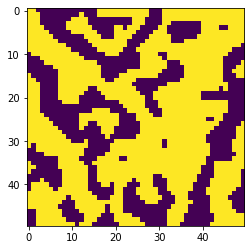

In [48]:
sub_images = crop_image_npix(binary_img, 50)
imshow(np.asarray(sub_images[300]))

We can then run the network centrality on this, and quantify the connectedness of the vegetation.

In [53]:
from pyveg.src.subgraph_centrality import subgraph_centrality, feature_vector_metrics

In [50]:
img_array = pillow_to_numpy(sub_images[300])
feature_vec, _ = subgraph_centrality(img_array)

The feature vector is the Euler Characteristic values for each quantile of vegetation-covered pixels, ordered by subgraph centrality.

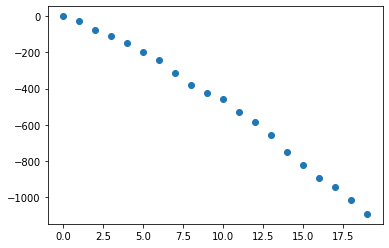

In [51]:
plt.plot(feature_vec,'o')

The single number we are using to quantify the connectedness is "offset50" - essentially the slope of the second half of the feature vector.

In [54]:
offset50 = feature_vector_metrics(feature_vec)["offset50"]
offset50

-635.0